In [ ]:
!pip install accelerate

In [ ]:
!pip install git+https://github.com/Pranavmath/diffusers.git

In [ ]:
!pip install datasets

In [4]:
from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter
import os
import torch
import numpy as np

In [10]:
IMAGE_SIZE = 256

In [ ]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    image_size = 256  # the generated image resolution
    train_batch_size = 1
    eval_batch_size = 1  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-nodules-128"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [11]:
from torchvision import transforms

image_preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

mask_preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ]
)

Use 🤗 Datasets' [set_transform](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.set_transform) method to apply the `preprocess` function on the fly during training:

## Create a UNet2DModel

Pretrained models in 🧨 Diffusers are easily created from their model class with the parameters you want. For example, to create a [UNet2DModel](https://huggingface.co/docs/diffusers/main/en/api/models/unet2d#diffusers.UNet2DModel):

In [ ]:
!mkdir unet

mkdir: cannot create directory ‘unet’: File exists


In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel.from_pretrained("./unet", use_safetensors=True)

It is often a good idea to quickly check the sample image shape matches the model output shape:

Great! Next, you'll need a scheduler to add some noise to the image.

## Train the model

By now, you have most of the pieces to start training the model and all that's left is putting everything together.

First, you'll need an optimizer and a learning rate scheduler:

In [ ]:
from accelerate import Accelerator
from diffusers import DDIMScheduler
from diffusers import DDIMPipeline
import math
import os


def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("L", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, pipeline, nodules, masks, save=False):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
        masks=masks,
        nodules=nodules
    ).images

    if save:
      # Make a grid out of the images
      image_grid = make_grid(images, rows=4, cols=4)

      # Save the images
      test_dir = os.path.join(config.output_dir, "samples")
      os.makedirs(test_dir, exist_ok=True)
      image_grid.save(f"{test_dir}/{0:04d}.png")

    return images

In [ ]:
import torch
from PIL import Image

accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        #gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )

model = accelerator.prepare(model.to("cuda"))
model = accelerator.unwrap_model(model)

noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
pipeline = DDIMPipeline(unet=model, scheduler=noise_scheduler)

In [53]:
import numpy as np
import json

metadata = json.load(open("./refineddataset/nodulemetadata.json"))
data = np.array([(bbox[2]-bbox[0], bbox[3]-bbox[1]) for bbox, _, _ in metadata.values()])

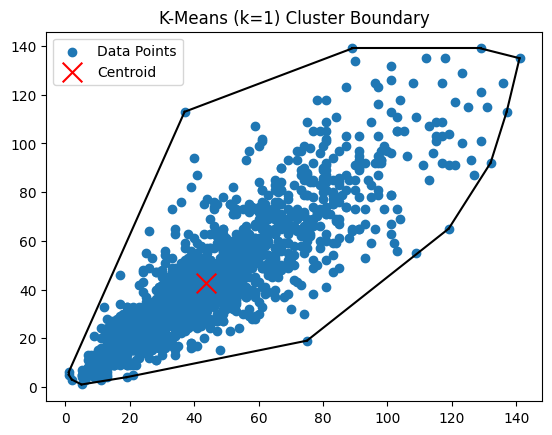

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull

def plot_kmeans_boundary(data):
    # Fit KMeans with k=1
    kmeans = KMeans(n_clusters=1, n_init=10)
    kmeans.fit(data)
    centroid = kmeans.cluster_centers_[0]
    
    # Compute convex hull to define boundary
    if len(data) > 2:  # ConvexHull requires at least 3 points
        hull = ConvexHull(data)
        hull_points = data[hull.vertices]
    else:
        hull_points = data  # If there are only 2 or fewer points, no hull
    
    # Plot data points
    plt.scatter(data[:, 0], data[:, 1], label='Data Points')
    plt.scatter(centroid[0], centroid[1], color='red', marker='x', s=200, label='Centroid')
    
    # Draw convex hull boundary
    if len(data) > 2:
        for simplex in hull.simplices:
            plt.plot(data[simplex, 0], data[simplex, 1], 'k-')
    
    plt.legend()
    plt.title("K-Means (k=1) Cluster Boundary")
    plt.show()

# Example usage
plot_kmeans_boundary(data)


In [ ]:
NUM_GENERATED = 10
i = 0
generated_nodule_dict = {}

for x in range(10, 150, 2):
  for y in range(10, 150, 2):
    xmin, ymin, xmax, ymax = IMAGE_SIZE - x//2, IMAGE_SIZE - y//2, IMAGE_SIZE + x//2, IMAGE_SIZE + y//2

    images = torch.full((NUM_GENERATED, 1, IMAGE_SIZE, IMAGE_SIZE), fill_value=-1)
    masks = torch.zeros((NUM_GENERATED, 1, IMAGE_SIZE, IMAGE_SIZE))
    masks[:, :, ymin:ymax, xmin:xmax] = 1

    images = evaluate(config, pipeline, images, masks)

    for image in images:
      fname = str(i).rjust(width=6, fillchar="0")
      image.save(f"./generatednodules/{fname}.jpg")
      generated_nodule_dict[fname] = (x, y)

In [ ]:
import json
with open('generatednodule.json', 'w') as f:
    json.dump(generated_nodule_dict, f)